# Algorithmic Trading Project

Generating price series

In [ ]:
#Library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA as arima
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import warnings

plt.style.use('dark_background')
rc('text', usetex=False)
warnings.filterwarnings("ignore")

We will be generating a price time series y using the following model:
$$\Delta y_t - d = \phi(\Delta y_{t-1} - d) + \epsilon_t + \theta \epsilon_{t-1}$$
with the following parameters:
* $t \in [0,2000]$
* $y_0 = y_1 = 100$
* $\phi = 0.6$
* $d = 0.025$
* $\theta = -0.4$
* $\epsilon \sim  N(0,1)$

In [ ]:
#Initialising random number generator with my student number
#np.random.seed(17088101)
generator = np.random.default_rng(17088101)
#generator = np.random.default_rng(88888888)
#Generating price series
t = np.arange(0,2001,1)
y = pd.Series(np.zeros(shape=(2001)))
y[0] = 100
y[1] = 100
phi = 0.6
d = 0.025
theta = -0.4
#epsilon = np.random.randn(2001)
epsilon = generator.normal(size=2001)
for i in range(2, len(y)):
    y[i] = phi*(y[i-1]-y[i-2]-d)+epsilon[i]+theta*epsilon[i-1]+d+y[i-1]
plt.plot(t,y,linewidth=1)
plt.title('Asset price time series',
         fontsize=20)
plt.ylabel(r'$y_t$')
plt.xlabel('$t$')
plt.fill_between(t, y.min()-10, y, alpha=0.3)
plt.xlim([t.min(), t.max()])
plt.ylim([y.min()-10, y.max()])
plt.grid(linewidth=0.3)

In [ ]:
#Splitting into train and test
train_size = int(0.7*len(y))
test_size = int(0.3*len(y))
train = y[:train_size]
test = y[train_size:]
plt.plot(train, linewidth=1, label='train')
plt.plot(test, linewidth=1, color='orange', label='test')
plt.fill_between(np.arange(len(train)), y.min()-10, train, alpha=0.3)
plt.fill_between(np.arange(len(train), len(y)), y.min()-10, test, alpha=0.3, 
                color='orange')
plt.title('Time series train and test split',
         fontsize=20)
plt.ylabel(r'$y_t$',
          fontsize=16)
plt.xlabel('$t$', 
          fontsize=16)
plt.xlim([t.min(), t.max()])
plt.ylim([y.min()-10, y.max()])
plt.grid(linewidth=0.3)
plt.legend(fontsize=15)

In [ ]:
#Reindexing for simplicity 
test = test.reset_index(drop=True)

## Defining Trading strategies
We will define three long-only self-financing trading strategies with initial capital $C_0$ of $10000$.

### Trend-Following (Momentum)

In [29]:
def trend_following_strategy_v2(data, time_window_short=3, 
                            time_window_long=6,
                            starting_cash=10000,
                            verbose=False):
    '''
    computes the portfolio value and logarithmic returns of a moving average cross-over strategy
    test = data
    time_window_short = short moving window
    time_window_long = long moving window
    starting_cash = starting capital employed in this self-financing strategy
    '''
    ma_short = data.rolling(window=time_window_short).mean()
    ma_long = data.rolling(window=time_window_long).mean()
    w = np.zeros(np.shape(data))
    C = np.zeros(np.shape(data))

    C[:time_window_long] = starting_cash # setting starting cash for the first x days
        #where x is the number of periods of the longer moving average
    for i in range(time_window_long-1, len(data)):
        if i < len(w)-1:
            #checking condition
            if ma_short[i] == ma_long[i]:
            #print('Do nothing')
            #this means that nothing should happen
                w[i+1] = w[i]
                C[i+1] = C[i]
            if ma_long[i] < ma_short[i]:
                #print('Buy asset')
                #trending upwards
                w[i+1] = C[i]/data[i]  + w[i] #we allocate all cash on the asset
                C[i+1] = 0 
                if verbose:
                    print('Long on asset at {}!'.format(data[i]))
                    print('Long_MA: {}, Short_MA: {}, w: {}, C: {}'.format(
                                        ma_long[i], ma_short[i], w[i+1], C[i+1]))
            if ma_long[i] > ma_short[i]:
                #print('Sell asset')
                C[i+1] = w[i]*data[i] + C[i] #we are allocating 0 cash on the asset
                w[i+1] = 0 
                if verbose:
                    print('Short on asset at {}!'.format(data[i]))
                    print('Long_MA: {}, Short_MA: {}, w: {}, C: {}'.format(
                                        ma_long[i], ma_short[i], w[i+1], C[i+1]))
    tf_strategy = pd.Series([a*b for a,b in zip(w,data)]+ C)   
    log_ret = np.log(tf_strategy) - np.log(tf_strategy.shift(1))
    cumulative_returns = (np.cumprod(1 + log_ret) - 1).iloc[-1]
    return tf_strategy, log_ret, cumulative_returns

In [30]:
def compute_benchmark(data, starting_cash=10000):
    '''
    computes the benchmark returns and portfolio value of a buy and hold strategy of an asset
    data = time series data to buy and hold
    starting_cash = starting capital employed in this self-financing strategy
    '''
    benchmark_time_series = starting_cash*data/data.iloc[0]
    log_ret = np.log(benchmark_time_series) - np.log(benchmark_time_series.shift(1))
    cumulative_returns = (np.cumprod(1 + log_ret) - 1).iloc[-1]
    return benchmark_time_series, log_ret, cumulative_returns

### Tuning window lengths
In order to optimise performance, we will tune the window lengths:
* short lengths $\in [3,15]$
* long lengths $\in [6, 30]$

Each score (cumulative return) will be appended to a matrix of returns, where the optimal parameters will be picked

In [31]:
short_time_windows = np.arange(3, 15, 1)
long_time_windows = [2*i for i in short_time_windows]
returns_matrix = np.zeros(shape=(len(short_time_windows), 
                                len(long_time_windows)))
#vertical = short time window
#horizontal = long time window
for i in range(len(short_time_windows)):
    for j in range(len(long_time_windows)):
        if i < j:
            tf_1, returns_trendfollowing, r_trendfollowing = trend_following_strategy_v2(train, 
                                                                    time_window_short=short_time_windows[i], 
                                                                    time_window_long=long_time_windows[j])
            returns_matrix[i, j] = r_trendfollowing

In [33]:
np.max(returns_matrix), compute_benchmark(train)[2]

(1.311586169911732, 0.7864377009486465)

The above score is the maximum return achieved with different window lengths, the matrix below is the entire matrix of returns (which is an upper triangular matrix as we are only aiming to test models if $$\textrm{long moving average} > \textrm{short moving average}$$

As we can see, in sample the model definitely outperforms the benchmark.

In [34]:
optimal_short_window = short_time_windows[
            int(np.where(returns_matrix==np.max(returns_matrix))[0])
            ]
optimal_long_window = long_time_windows[
            int(np.where(returns_matrix==np.max(returns_matrix))[0])
            ]
print('The optimal window lengths in sample are {} and {}'.format(optimal_short_window, optimal_long_window))

The optimal window lengths in sample are 3 and 6


### Comparing in-sample with out-of sample performance
The two graphs below will show portfolio performance in and out of sample, with the optimised hyperparameters in the training set

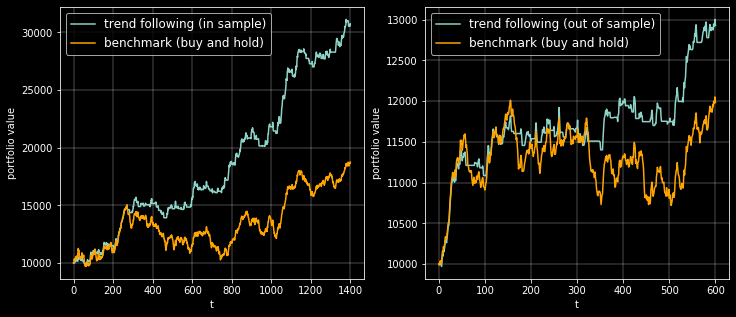

In [35]:
tf_insample, returns_trendfollowing_insample, r_trendfollowing_insample = trend_following_strategy_v2(train, 
                                                            time_window_short=optimal_short_window, 
                                                            time_window_long=optimal_long_window,
                                                            verbose=False)
tf_oosample, returns_trendfollowing_oosample, r_trendfollowing_oosample = trend_following_strategy_v2(test, 
                                                            time_window_short=optimal_short_window, 
                                                            time_window_long=optimal_long_window,
                                                            verbose=False)
benchmark_timeseries_insample, benchmark_returns_insample, r_benchmark_insample = compute_benchmark(train, 
                                                            starting_cash=10000)
benchmark_timeseries_oosample, benchmark_returns_oosample, r_benchmark_oosample = compute_benchmark(test, 
                                                            starting_cash=10000)

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(np.arange(len(train)), tf_insample, 
        label='trend following (in sample)',
        linewidth=1.5)
axs[0].plot(np.arange(len(train)), benchmark_timeseries_insample,
        label='benchmark (buy and hold)',
        linewidth=1.5,
        color='orange')
axs[0].set_xlabel('t')
axs[0].set_ylabel('portfolio value')
axs[0].legend(fontsize=12)
axs[0].grid(linewidth=0.3)
axs[1].plot(np.arange(len(test)), tf_oosample, 
        label='trend following (out of sample)',
        linewidth=1.5)
axs[1].plot(np.arange(len(test)), benchmark_timeseries_oosample,
        label='benchmark (buy and hold)',
        linewidth=1.5,
        color='orange')
axs[1].set_xlabel('t')
axs[1].set_ylabel('portfolio value')
axs[1].grid(linewidth=0.3)
axs[1].legend(fontsize=12)

### Mean-reverting strategy (EWMA)

In [36]:
def mean_reversion_ewma(data, window=10, starting_cash=10000,
                       verbose=False):
    '''
    performs a mean-reverting strategy baed on EWMA
    '''
    ewma = data.ewm(span=window).mean()
    w = np.zeros(np.shape(data))
    C = np.zeros(np.shape(data))
    C[:window] = starting_cash # setting starting cash for the first x days
    #where x is the number of periods of the longer moving average
    for i in range(window-1, len(data)):
        if i < len(w)-1:
            #check if asset is held, if it is, sell it 
            if ewma[i] >= data[i]:
                #print('Buy asset')
                #trending upwards
                w[i+1] = C[i]/data[i]  + w[i] #we allocate all cash on the asset
                C[i+1] = 0 
                if verbose:
                    print('Long on asset at {}!'.format(data[i]))
                    print('ewma: {}, price: {}, w: {}, C: {}'.format(
                                        ewma[i], data[i], w[i+1], C[i+1]))
            else:
                w[i+1] = w[i]
                C[i+1] = C[i]
            if w[i]!=0:
                if ewma[i] < data[i]:
                    C[i+1] = w[i]*data[i] + C[i] #we are allocating 0 cash on the asset
                    w[i+1] = 0 
                    if verbose:
                        print('Short on asset at {}!'.format(data[i]))
                        print('ewma: {}, asset: {}, w: {}, C: {}'.format(
                                            ewma[i], data[i], w[i+1], C[i+1])) 
            
    tf_strategy = pd.Series([a*b for a,b in zip(w,data)]+ C)   
    log_ret = np.log(tf_strategy) - np.log(tf_strategy.shift(1))
    cumulative_returns = np.cumprod(1 + log_ret) - 1
    return tf_strategy, log_ret, cumulative_returns

In [37]:
windows = np.arange(10,20)
opt_returns_array = np.zeros(len(windows))
for i in range(len(windows)):
    mr, returns_mr, r_mr = mean_reversion_ewma(train, window=windows[i])
    opt_returns_array[i] = r_mr.iloc[-1]

In [38]:
np.max(opt_returns_array)
optimal_window = windows[
            int(np.where(np.max(opt_returns_array[opt_returns_array!=0]))[0])
            ]

In [39]:
optimal_window

10

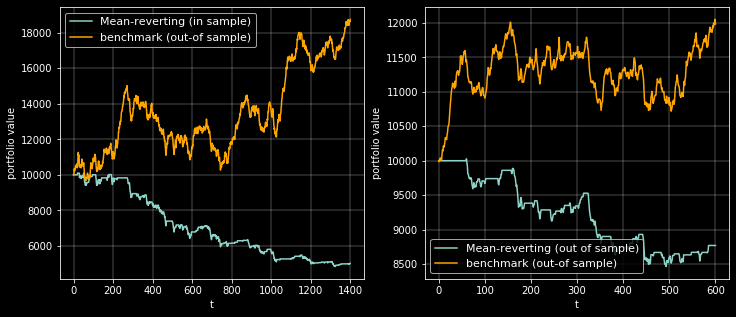

In [40]:
mr_insample, returns_mr_insample, r_mr_insample = mean_reversion_ewma(train, 
                                                            window=optimal_window,
                                                            verbose=False)
mr_oosample, returns_mr_oosample, r_mr_oosample = mean_reversion_ewma(test, 
                                                            window=optimal_window, 
                                                            verbose=False)
benchmark_timeseries_insample, benchmark_returns_insample, r_benchmark_insample = compute_benchmark(train, 
                                                            starting_cash=10000)
benchmark_timeseries_oosample, benchmark_returns_oosample, r_benchmark_oosample = compute_benchmark(test, 
                                                            starting_cash=10000)

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(np.arange(len(train)), mr_insample, 
        label='Mean-reverting (in sample)',
        linewidth=1.5)
axs[0].plot(np.arange(len(train)), benchmark_timeseries_insample,
        label='benchmark (out-of sample)',
        linewidth=1.5,
        color='orange')
axs[0].set_xlabel('t')
axs[0].set_ylabel('portfolio value')
axs[0].legend(fontsize=11)
axs[0].grid(linewidth=0.3)
axs[1].plot(np.arange(len(test)), mr_oosample, 
        label='Mean-reverting (out of sample)',
        linewidth=1.5)
axs[1].plot(np.arange(len(test)), benchmark_timeseries_oosample,
        label='benchmark (out-of sample)',
        linewidth=1.5,
        color='orange')
axs[1].set_xlabel('t')
axs[1].set_ylabel('portfolio value')
axs[1].grid(linewidth=0.3)
axs[1].legend(fontsize=11, loc='lower left')

## Autoregressive trading model (AR)

In [41]:
def train_AR(data, time_window=10, starting_cash=10000):
    '''
    trains an autoregressive model 
    window = window of data to train on
    data = initial data input 
    starting_cash = starting capital to invest
    '''
    ar_prediction = np.zeros(np.shape(data))
    data_diff = np.diff(data)
    diff_prediction = np.zeros(np.shape(data_diff))
    for i, x in enumerate(data_diff[:-1], 0):
        diff_prediction[i] = x #first prediction set to initial value
        if i>=time_window: #The amount of observations to train is time window
            X = data_diff[:i] 
            train = X 
            # train autoregression
            model = AR(train)
            model_fit = model.fit()
            #a prediction will be created ONLY at the index of the length of the given trained set
            predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
            diff_prediction[i] = predictions[0]
    #Undifferencing the data
    ar_prediction[0] = data[0]
    for i in range(len(ar_prediction)-1):
        ar_prediction[i+1] = data[i] + diff_prediction[i]
    return diff_prediction, ar_prediction

In [42]:
def trade_AR(original_data, starting_cash=10000,
            time_window=10):
    '''
    will trade based on the previously predicted values in a trend-following manner
    this means if the price is higher than the predicted price, the algorithm will buy
    original_data = original timeseries
    time_window = time window to train the AR model with
    starting_cash = initial capital to invest in the self-financing strategy
    '''
    ar_prediction = train_AR(original_data,
                            time_window=time_window)[1]
    w = np.zeros(np.shape(ar_prediction))
    cash = np.zeros(np.shape(ar_prediction))
    cash[0] = starting_cash #initial cash set to this
    for i, x in enumerate(original_data[:-1], 0):
        if ar_prediction[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]
        if ar_prediction[i] < x: 
            w[i+1] = cash[i]/x  + w[i]
            cash[i+1] = 0
        if ar_prediction[i] > x:
            cash[i+1] = w[i]*x + cash[i]
            w[i+1] = 0
    ar_strategy = [a*b for a,b in zip(w,original_data)]+ cash
    return ar_strategy, ar_prediction

In [43]:
def compute_log_ret(timeseries):
    '''
    function to compute logarithmic returns for each time step
    inputs a time series of portfolio values and returns logarithmic returns
    and cumulative returns over the period
    '''
    series = pd.Series(timeseries)
    log_ret = np.log(series) - np.log(series.shift(1))
    cumulative_returns = (np.cumprod(1 + log_ret) - 1).iloc[-1]
    return log_ret, cumulative_returns

In [44]:
windows = [10, 20, 50, 100, 200]
cum_ret_ar = np.zeros(len(windows))
for i in range(len(windows)):
    returns_log, cumulative_log = compute_log_ret(trade_AR(train, 
                                                time_window=windows[i])[0])
    cum_ret_ar[i] = cumulative_log

In [45]:
cum_ret_ar

array([2.81413562, 2.90810497, 2.58630293, 2.25842471, 1.96571866,
       1.23508045])

So the best return is given with a window of 20

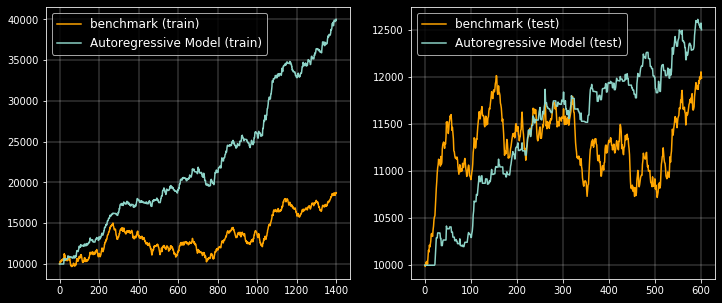

In [46]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
cash = np.zeros(np.shape(train))
T = len(train)
N = len(train)
t = np.linspace(0, T, N)
cash[0] = 10000
axs[0].plot(t, cash[0]*train/train[0],
            label='benchmark (train)', color='orange',
            linewidth=1.5)
axs[0].plot(t, trade_AR(train, time_window=20)[0],
        label='Autoregressive Model (train)',
        linewidth=1.5)
axs[0].legend(fontsize=12)
axs[0].grid(linewidth=0.3)

T = len(test)
N = len(test)
t = np.linspace(0, T, N)
cash = np.zeros(np.shape(test))
cash[0] = 10000
axs[1].plot(t, cash[0]*test/test[0],
        label='benchmark (test)', color='orange',
        linewidth=1.5)
axs[1].plot(t, trade_AR(test, time_window=20)[0],
        label='Autoregressive Model (test)',
        linewidth=1.5)
axs[1].legend(fontsize=12)
axs[1].grid(linewidth=0.3)

In [47]:
ar_strat_insample = trade_AR(train, time_window=20)[0]
T = len(train)
N = len(train)
t_ar_insample = np.linspace(0, T, N)

ar_strat_oosample = trade_AR(test, time_window=20)[0]
T = len(test)
N = len(test)
t_ar_oosample = np.linspace(0, T, N)

## Comparison of the three trading strategies

Text(0, 0.5, 'portfolio value')

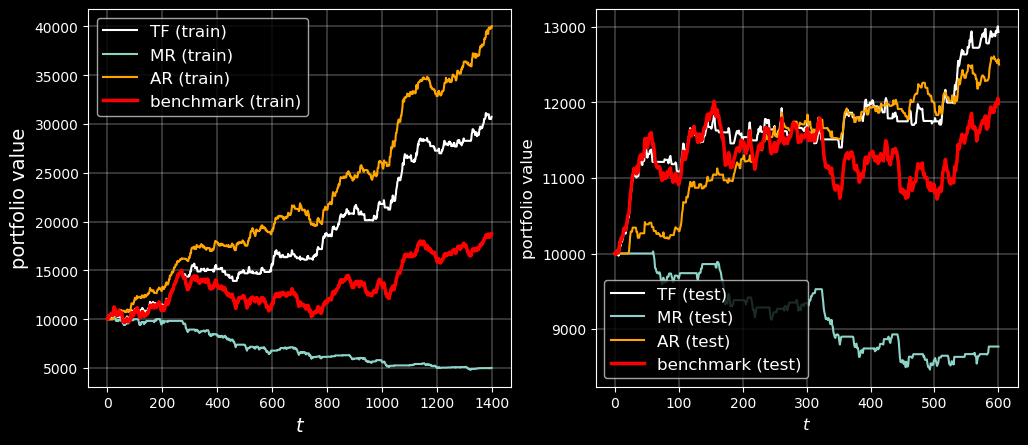

In [48]:
fig, axs = plt.subplots(1,2, figsize=(12,5),
                       dpi=100)
axs[0].plot(np.arange(len(train)), tf_insample, 
        label='TF (train)',
        linewidth=1.5, color='white')
axs[0].plot(np.arange(len(train)), mr_insample, 
        label='MR (train)',
        linewidth=1.5)
axs[0].plot(t_ar_insample, ar_strat_insample,
           label='AR (train)',
           linewidth=1.5, color='orange')
axs[0].grid(linewidth=0.3)
axs[0].plot(np.arange(len(train)), benchmark_timeseries_insample,
        label='benchmark (train)',
        linewidth=2.5,
        color='red')
axs[0].legend(fontsize=12)
axs[0].set_xlabel('$t$',
                 fontsize=14)
axs[0].set_ylabel('portfolio value',
                 fontsize=14)
#---------------------------------------------------------------------------
axs[1].plot(np.arange(len(test)), tf_oosample, 
        label='TF (test)',
        linewidth=1.5, color='white')
axs[1].plot(np.arange(len(test)), mr_oosample, 
        label='MR (test)',
        linewidth=1.5)
axs[1].plot(t_ar_oosample, ar_strat_oosample,
           label='AR (test)',
           linewidth=1.5, color='orange')
axs[1].grid(linewidth=0.3)
axs[1].plot(np.arange(len(test)), benchmark_timeseries_oosample,
        label='benchmark (test)',
        linewidth=2.5,
        color='red')
axs[1].legend(fontsize=12,
             loc='lower left')
axs[1].set_xlabel('$t$',
                 fontsize=12)
axs[1].set_ylabel('portfolio value',
                 fontsize=12)

# Performance Measurement

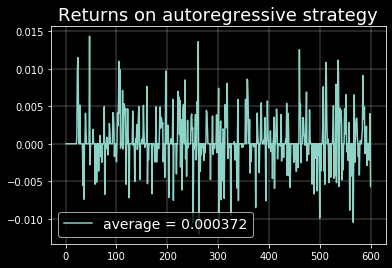

In [159]:
#Plotting the returns that the strategy gets over the cumulative time period
ar_timeseries_insample = pd.Series(ar_strat_insample)
ar_timeseries_oosample = pd.Series(ar_strat_oosample)
returns_timeseries_ar = compute_log_ret(ar_strat_oosample)[0]
returns_timeseries_ar_insample = compute_log_ret(ar_strat_insample)[0]
average_return_daily = returns_timeseries_ar.mean()
plt.title('Returns on autoregressive strategy',
         fontsize=18)
plt.plot(returns_timeseries_ar, label='average = {}'.format(round(average_return_daily, 6)),
        linewidth=1.5)
plt.legend(fontsize=14, loc='lower left')
plt.grid(linewidth=0.3)

### Sharpe Ratio
Sharpe Ratio = $\frac{\mu}{\sigma}$ , where $\mu$ is the average return and $\sigma$ is the volatility

In [160]:
def compute_sharpe_annualised(returns_timeseries):
    mu_timeseries = returns_timeseries.mean()
    sigma_timeseries = returns_timeseries.std()
    sharpe_timeseries = mu_timeseries/sigma_timeseries
    return sharpe_timeseries * np.sqrt(252)

In [265]:
annual_sharpe_tf_insample = compute_sharpe_annualised(returns_trendfollowing_insample)
annual_sharpe_mr_insample = compute_sharpe_annualised(returns_mr_insample)
annual_sharpe_ar_insample = compute_sharpe_annualised(returns_timeseries_ar_insample)
print('SR tf: {}, SR mr: {}, SR ar: {}'.format(annual_sharpe_tf_insample,
                                              annual_sharpe_mr_insample,
                                              annual_sharpe_ar_insample))
print('------------------------------------------------------------------------------')
annual_sharpe_tf = compute_sharpe_annualised(returns_trendfollowing_oosample)
annual_sharpe_mr = compute_sharpe_annualised(returns_mr_oosample)
annual_sharpe_ar = compute_sharpe_annualised(returns_timeseries_ar)
print('SR tf: {}, SR mr: {}, SR ar: {}'.format(annual_sharpe_tf,
                                              annual_sharpe_mr,
                                              annual_sharpe_ar))

SR tf: 2.100258991755686, SR mr: -1.4252765123811153, SR ar: 2.7452855374147402
------------------------------------------------------------------------------
SR tf: 1.7545381650767609, SR mr: -1.114546695881482, SR ar: 1.792161899260805


### Maximum drawdown

In [71]:
def max_dd(price_timeseries):
    window = len(price_timeseries)
    rolling_max = price_timeseries.rolling(window, min_periods=1).max()
    daily_dd = price_timeseries/rolling_max - 1.0
    max_daily_dd = daily_dd.rolling(window, min_periods=1).min()
    return daily_dd, max_daily_dd

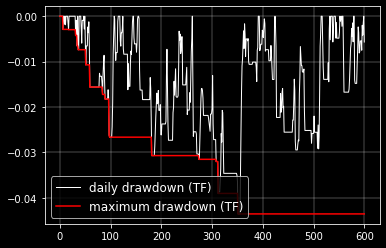

In [72]:
daily_dd_tf, max_dd_tf = max_dd(tf_oosample)
plt.plot(daily_dd_tf, color='white',
        linewidth=1, label='daily drawdown (TF)')
plt.plot(max_dd_tf, color='red',
        linewidth=1.5, label='maximum drawdown (TF)')
plt.legend(fontsize=12)
plt.grid(linewidth=0.3)

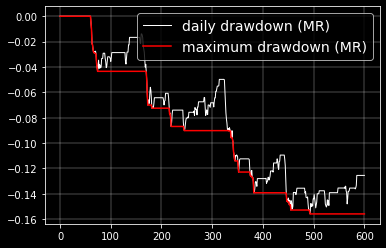

In [73]:
daily_dd_mr, max_dd_mr = max_dd(mr_oosample)
plt.plot(daily_dd_mr, color='white',
        linewidth=1, label='daily drawdown (MR)')
plt.plot(max_dd_mr, color='red',
        linewidth=1.5, label='maximum drawdown (MR)')
plt.legend(fontsize=14)
plt.grid(linewidth=0.3)

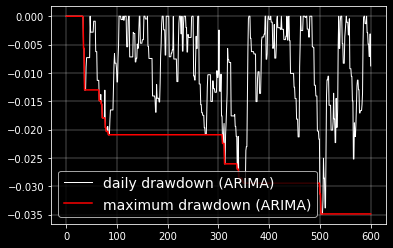

In [74]:
daily_dd_ar, max_dd_ar = max_dd(ar_timeseries_oosample)
plt.plot(daily_dd_ar, color='white',
        linewidth=1, label='daily drawdown (ARIMA)')
plt.plot(max_dd_ar, color='red',
        linewidth=1.5, label='maximum drawdown (ARIMA)')
plt.legend(fontsize=14)
plt.grid(linewidth=0.3)

In [75]:
print('MDD tf: {}, MDD mr: {}, MDD ar: {}'.format(
    max_dd_tf.min(), max_dd_mr.min(), max_dd_ar.min()))

MDD tf: -0.04356623081794597, MDD mr: -0.15579516479175048, MDD ar: -0.03488892493928131


### Calmar Ratio
The ratio is defined as following: Calmar = $\frac{\mu}{MDD}$

In [76]:
def compute_calmar_annualised(price_timeseries):
    log_ret = np.log(price_timeseries) - np.log(price_timeseries.shift(1))
    MDD = np.absolute(max_dd(price_timeseries)[1].min())
    mean_return = log_ret.mean()
    calmar_daily = mean_return / MDD
    return calmar_daily * np.sqrt(252)

In [165]:
print('Calmar tf: {}, Calmar mr: {}, Calmar ar: {}'.format(
    compute_calmar_annualised(tf_insample), 
    compute_calmar_annualised(mr_insample), 
    compute_calmar_annualised(ar_timeseries_insample)))
print('-------------------------------------------------------------------------------------')
print('Calmar tf: {}, Calmar mr: {}, Calmar ar: {}'.format(
    compute_calmar_annualised(tf_oosample), 
    compute_calmar_annualised(mr_oosample), 
    compute_calmar_annualised(ar_timeseries_oosample)))

Calmar tf: 0.11288500658558763, Calmar mr: -0.015081502919686912, Calmar ar: 0.14988051921893195
-------------------------------------------------------------------------------------
Calmar tf: 0.1560535977189662, Calmar mr: -0.022300118424992927, Calmar ar: 0.1690992270727541


# Adjusting Sharpe Ratios

In [297]:
T = len(test)
#adjustment_df = np.sqrt(252)
adjustment_df = 252
#adjustment_df = 1
df = (T/adjustment_df) -1

t_stat_tf = annual_sharpe_tf_insample*np.sqrt(T/adjustment_df)
p_tf_insample = stats.t.sf(t_stat_tf, df)

t_stat_mr = annual_sharpe_mr_insample*np.sqrt(T/adjustment_df)
p_mr_insample = stats.t.sf(t_stat_mr, df)

t_stat_ar = annual_sharpe_ar_insample*np.sqrt(T/adjustment_df)
p_ar_insample = stats.t.sf(t_stat_ar, df)

In [298]:
p_tf_insample, p_mr_insample, p_ar_insample

(0.06613059928025501, 0.8938396640255921, 0.04676343672905871)

In [299]:
T = len(test)
adjustment_df = np.sqrt(252)
adjustment_df = 252
df = (T/adjustment_df) -1

t_stat_tf = annual_sharpe_tf*np.sqrt(T/adjustment_df)
p_tf_oosample = stats.t.sf(t_stat_tf, df)

t_stat_mr = annual_sharpe_mr*np.sqrt(T/adjustment_df)
p_mr_oosample = stats.t.sf(t_stat_mr, df)

t_stat_ar = annual_sharpe_ar*np.sqrt(T/adjustment_df)
p_ar_oosample = stats.t.sf(t_stat_ar, df)

p_tf_oosample, p_mr_oosample, p_ar_oosample

(0.08279401158466157, 0.8603914436896447, 0.08066132337062104)

### Bonferroni adjustments to the p-values
Each p-value will be multiplied by N, where N is the number of models tested for each strategy

In [315]:
#N_tf = len(returns_matrix[returns_matrix!=0.0])
N_tf = 3
p_insample_adjusted_tf = p_tf_insample*N_tf
#print(tf_insample_adjusted)
t_tf = stats.t.isf(p_insample_adjusted_tf, df)
t_tf/np.sqrt(T/adjustment_df)

0.775637689054206

In [316]:
#N_ar = len(windows)
N_ar = 3
p_insample_adjusted_ar = p_ar_insample*N_ar
#print(tf_insample_adjusted)
t_ar = stats.t.isf(p_insample_adjusted_ar, df)
t_ar/np.sqrt(T/adjustment_df)

1.109436601264487

In [317]:
#N_ar = len(windows)
N_mr = 3
p_insample_adjusted_mr = p_mr_insample*N_mr
#print(tf_insample_adjusted)
t_mr = stats.t.isf(p_insample_adjusted_mr, df)
t_mr/np.sqrt(T/adjustment_df)

nan

----------------------------------------------------------------------

In [318]:
#N_tf = len(returns_matrix[returns_matrix!=0.0])
N_tf = 3
p_oosample_adjusted_tf = p_tf_oosample*N_tf
#print(tf_insample_adjusted)
t_tf = stats.t.isf(p_oosample_adjusted_tf, df)
t_tf/np.sqrt(T/adjustment_df)

0.5831648411227297

In [319]:
#N_ar = len(windows)
N_ar = 3
p_oosample_adjusted_ar = p_ar_oosample*N_ar
#print(tf_insample_adjusted)
t_ar = stats.t.isf(p_oosample_adjusted_ar, df)
t_ar/np.sqrt(T/adjustment_df)

0.6048361277637029

In [320]:
#N_ar = len(windows)
N_mr = 3
p_oosample_adjusted_mr = p_mr_oosample*N_mr
#print(tf_insample_adjusted)
t_mr = stats.t.isf(p_oosample_adjusted_mr, df)
t_mr/np.sqrt(T/adjustment_df)

nan